In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.SW_sqrt import psi_ln_sw
from operators.SW import solve_poisson_equation_two_stream, total_mass, total_momentum, total_energy_k

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mycolorpy import colorlist as mcp
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Bump-on-tail Instability SW

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution
epsilon = 0.03
# velocity scaling of electron and ion
alpha_e1 = 1
alpha_e2 = 0.5
alpha_i = np.sqrt(1 / 1863)
# x grid is from 0 to L
L = 20 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# final time
T = 20
# velocity scaling
u_e1 = 0
u_e2 = 4.5
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-8, 8, int(1e5))
# spatial grid 
x = np.linspace(0, L, Nx)

In [6]:
# load simulation data
sol_midpoint_u = np.load("../data/SW/bump_on_tail/sol_midpoint_u_" + str(Nv) + ".npy")
sol_midpoint_t = np.load("../data/SW/bump_on_tail/sol_midpoint_t_" + str(Nv) + ".npy")

# print shape of simulation data
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20005, 2001)
(2001,)


In [7]:
# initialize the electric potential
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [8]:
# initialize the states 
state_e1_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the Vlasov-Poisson system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv*(Nx-1) + jj*(Nx-1): Nv*(Nx-1) + (jj+1)*(Nx-1), ii]
        # static/background ions
        state_i_midpoint[0, :, ii] = (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * np.ones(Nx-1) / alpha_i
    
    E_midpoint[:-1, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii],
                                                              state_e2=state_e2_midpoint[:, :, ii],
                                                              state_i=state_i_midpoint[:, :, ii],
                                                              alpha_e1=alpha_e1,
                                                              alpha_e2=alpha_e2,
                                                              alpha_i=alpha_i, 
                                                              dx=dx, 
                                                              Nx=Nx-1, 
                                                              Nv=Nv, L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

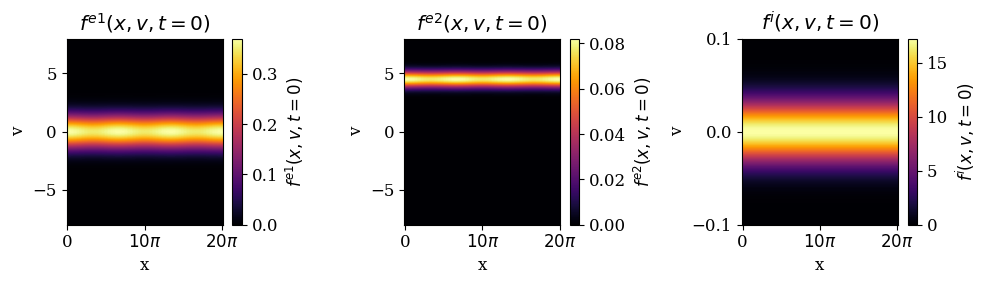

In [9]:
# plot initial condition
fig, ax = plt.subplots(ncols=3, sharey=False, figsize=(10, 3))
f_0e1 = np.outer(np.append(state_e1_midpoint[0, :, 0], state_e1_midpoint[0, 0, 0]), psi_ln_sw((v-u_e1)/alpha_e1, n=0))
pos = ax[0].pcolormesh(x, v, (f_0e1).T, cmap="inferno")
ax[0].set_xlabel("x")
ax[0].set_xticks([0, 10*np.pi, 20*np.pi])
ax[0].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[0].set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e1}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e1}(x, v, t=0)$")

f_0e2 = np.outer(np.append(state_e2_midpoint[0, :, 0], state_e2_midpoint[0, 0, 0]), psi_ln_sw((v-u_e2)/alpha_e2, n=0))
pos = ax[1].pcolormesh(x, v, (f_0e2).T, cmap="inferno")
ax[1].set_xticks([0, 10*np.pi, 20*np.pi])
ax[1].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[1].set_xlabel("x")
ax[1].set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e2}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{e2}(x, v, t=0)$")

f_0i = np.outer(np.append(state_i_midpoint[0, :, 0], state_i_midpoint[0, 0, 0]), psi_ln_sw((v-u_i)/alpha_i, n=0))
pos = ax[2].pcolormesh(x, v, (f_0i).T, cmap="inferno")
ax[2].set_xticks([0, 10*np.pi, 20*np.pi])
ax[2].set_xticklabels([r"0", r"$10\pi$", r"$20\pi$"])
ax[2].set_xlabel("x")
ax[2].set_ylabel("v")
ax[2].set_yticks([-0.1, 0, 0.1])
ax[2].set_ylim(-0.1, 0.1)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[2].set_title("$f^{i}(x, v, t=0)$")

plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/initial_condition_bump_on_tail.png", dpi=600)

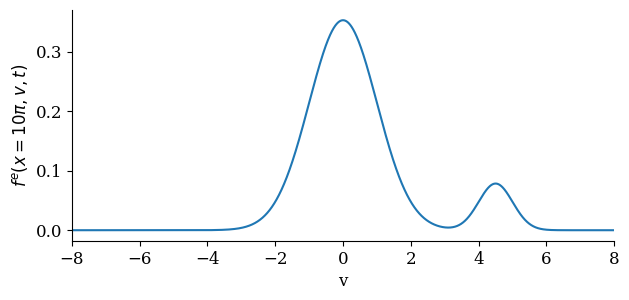

In [10]:
fig, ax = plt.subplots(figsize=(7, 3))
_ = plt.plot(v, (f_0e1[55, :]+ f_0e2[55, :]))
_ = ax.set_xlabel("v")
_ = ax.set_ylabel("$f^{e}(x=10\pi, v, t)$")
_ = ax.set_xlim(-8, 8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [11]:
# save electric field solution for the bump-on-tail instability 
np.save("../data/SW/bump_on_tail/sol_midpoint_e_" + str(Nv)+ ".npy", E_midpoint)

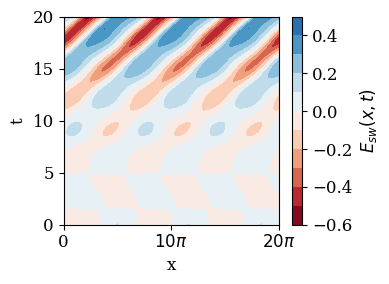

In [12]:
# plot electric field
fig, ax = plt.subplots(figsize=(4, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=10, vmax=0.6, vmin=-0.6)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E_{sw}(x, t)$", rotation=90)
cbar.ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_xticks([0, 10*np.pi, 20*np.pi])
ax.set_xticklabels([r"0", r"$10\pi$",  r"$20\pi$"])
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_electric_field_SW" + str(Nv) + ".png", dpi=600)

In [13]:
# compute the amplitude of the electric field wavelength k=1 for bump-on-tail
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

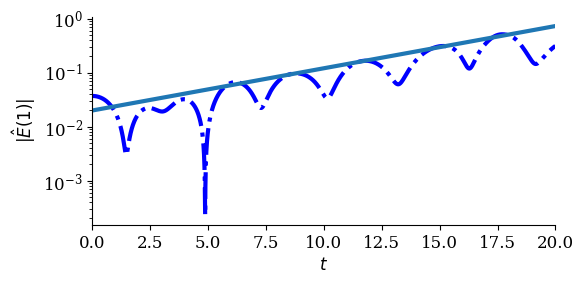

In [14]:
# plot growth rate
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-.", c="blue", linewidth=3)
gamma = 0.18
ax.plot(sol_midpoint_t, np.exp(gamma*sol_midpoint_t)*2e-2, linewidth=3)

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_electric_growth_rate_"+ str(Nv) + ".png", dpi=600)

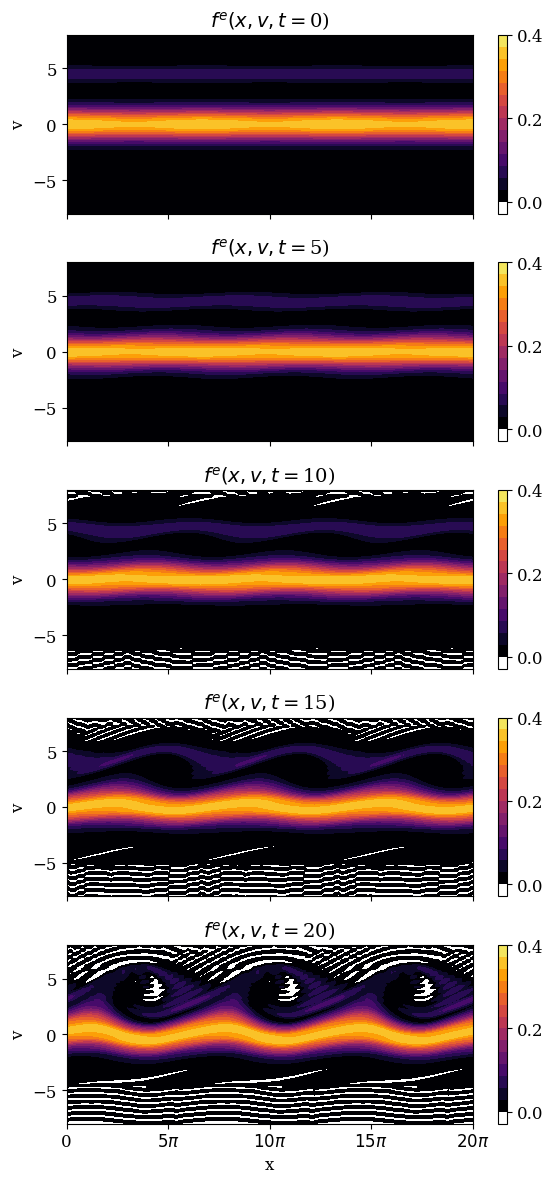

In [15]:
# plot phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)/4))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))+ np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.4, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.2, 0.4])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=14)
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_evolution_SW_" + str(Nv) + ".png", dpi=600)

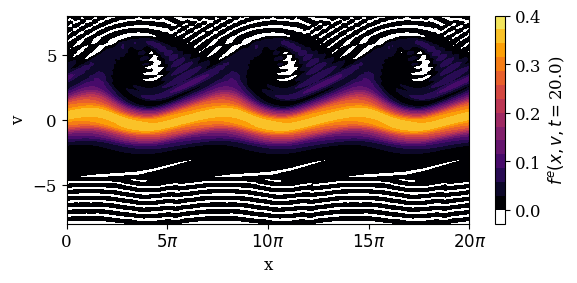

In [16]:
# plot the distribution function in phase space at the last timestamp 
fig, ax = plt.subplots(figsize=(6, 3))
ii = -1
distribution = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))+ np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
levels = np.append(-0.1, np.linspace(0, 0.4, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
ax.set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_electron_distribution_SW_" + str(Nv) + ".png", dpi=600)

In [17]:
distribution_sw_sqrt = np.load("../data/SW_sqrt/bump_on_tail/distribution_20_" + str(Nv) + ".npy")

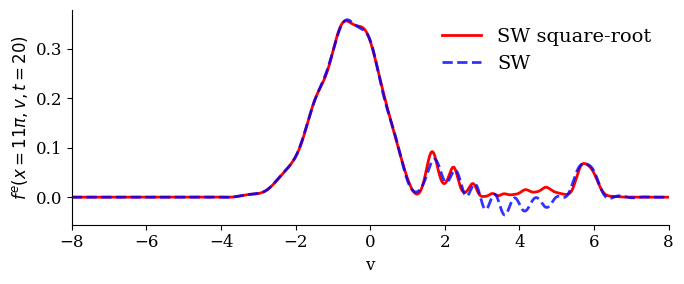

In [20]:
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
_ = ax.plot(v, distribution_sw_sqrt[11 * Nx//20, :], c="red", ls="-", linewidth=2, alpha=1, label="SW square-root")
_ = ax.plot(v, distribution[11 * Nx//20, :], c="blue", ls="--", linewidth=2, alpha=0.8, label="SW")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("v")
ax.set_ylabel("$f^{e}(x=11\pi, v, t=20)$")
ax.set_xlim(-8, 8)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/filamentation_bump_on_tail_" + str(Nv) + ".png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [22]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv)\
                       +total_mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv)\
                       +total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

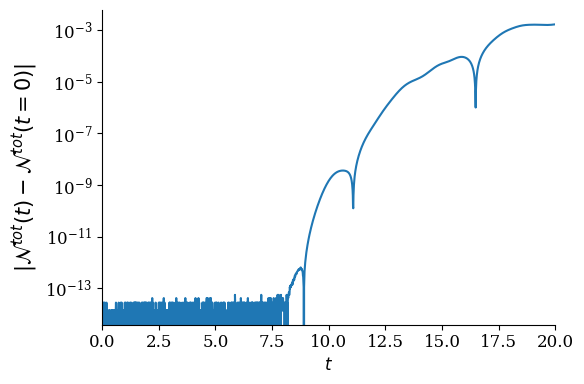

In [23]:
# plot mass evolution
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [24]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, m_s=m_e1, u_s=u_e1)\
                           +total_momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, m_s=m_e2, u_s=u_e2)\
                           +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)
    

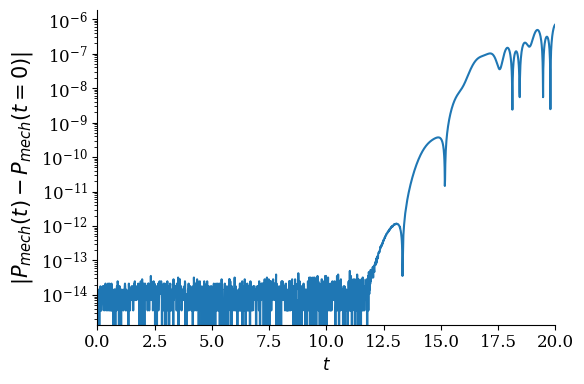

In [25]:
# plot momentum evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [31]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, m_s=m_e1, u_s=u_e1)\
                           +total_energy_k(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, m_s=m_e2, u_s=u_e2)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:-1, ii])**2)

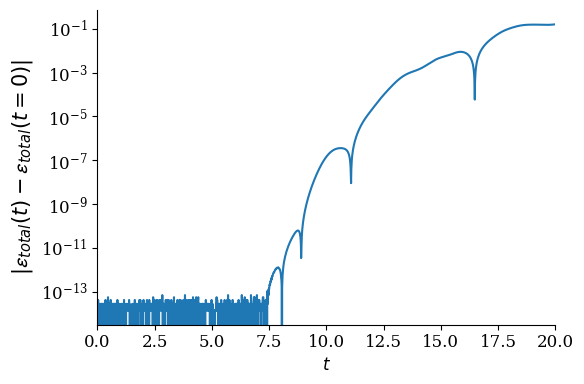

In [32]:
# plot energy evolution
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

In [33]:
# load SW square-root results
energy_k_sw_sqrt = np.load("../data/SW_sqrt/bump_on_tail/kinetic_energy_" + str(Nv)+ ".npy")
energy_p_sw_sqrt = np.load("../data/SW_sqrt/bump_on_tail/potential_energy_" + str(Nv) + ".npy")

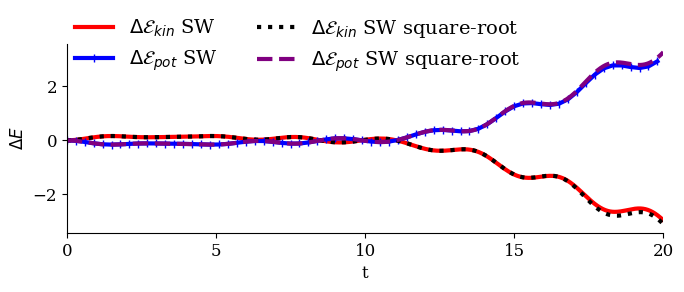

In [34]:
# plot exchage of kinetic and potential energy 
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))

_ = plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], c="red", ls="-", linewidth=3,  label="$\Delta \mathcal{E}_{kin}$ SW")
_ = plt.plot(sol_midpoint_t[::30], energy_p_midpoint[::30]- energy_p_midpoint[0], "-|", c="blue", linewidth=3, label="$\Delta \mathcal{E}_{pot}$ SW")

_ = plt.plot(sol_midpoint_t, energy_k_sw_sqrt- energy_k_sw_sqrt[0], c="black", ls=":", linewidth=3, label="$\Delta \mathcal{E}_{kin}$ SW square-root")
_ = plt.plot(sol_midpoint_t, energy_p_sw_sqrt- energy_p_sw_sqrt[0], "--", c="purple", linewidth=3, label="$\Delta \mathcal{E}_{pot}$ SW square-root")


_ = plt.legend()
_ = plt.xlim(0, T)
_ = ax.set_xticks([0, 5, 10, 15, 20])
_ = plt.xlabel("t")
_ = plt.ylabel("$\Delta E$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=14, loc=(0, 0.8))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/energy_exchange_" + str(Nv) + "_bump_on_tail.png", bbox_inches='tight', dpi=600)

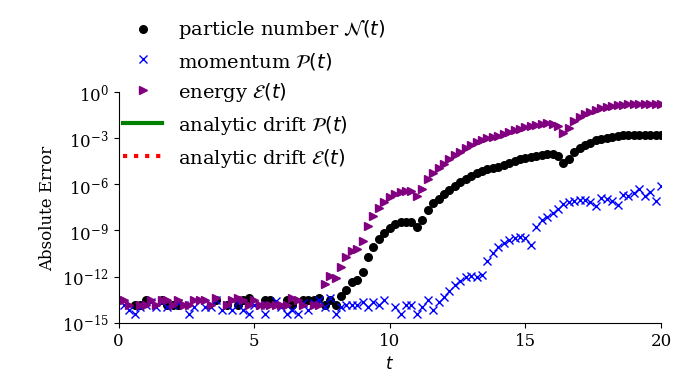

In [35]:
# plot overall conservation properties 
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
#ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), "--", c="orange", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$ ")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.set_ylim(10**-15, 10**0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fontsize=14, loc='upper center', bbox_to_anchor=(0.25, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/bump_on_tail/conservation_" + str(Nv) + "_bump_on_tail_SW.png", bbox_inches='tight', dpi=600)